In [290]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

#os.chdir("../../..")

In [291]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd

In [292]:
#!pip install pyarrow

In [293]:
pwd

'/home/mail12/Nerf-diffusion/covid_19/FINAL/LSTM'

In [294]:
fix_seed = 2021
import random
import torch
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

In [295]:
#from pytorch_forecasting.data.examples import get_stallion_data
data = pd.read_csv("brazil_patch.csv")
data = data.drop(columns=['Unnamed: 0','date','Gathering','Transport'])
cols = data.columns.tolist()
cols = cols[-1:]+cols[:-1]
k3 =data[cols]

In [296]:
# from pandas import read_csv
# from matplotlib import pyplot
# # load dataset
# dataset = data
# values = dataset.values


In [297]:
# # Choose Country
# data_interest = data.loc[data["Country"] == "Brazil"]
# data_interest

In [298]:
# # validate
# #data_clear = data_interest.drop(columns = ["Date","Country","Cumulative","Cases","TRUE","7-day"])

# # previous 
# #data_clear = data_interest.drop(columns = ["Deaths", "Date","Confirmed","Recovered","TRUE","Confirmed","Country","7-day"])

# # forecast
# data_clear = data_interest.drop(columns = ["Date","Country","Cumulative","Cases","TRUE","7-day"])
# data_clear

In [299]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# This has been taken from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/ 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = k3
values = dataset.values 
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)
reframed.drop(reframed.columns[[5,6,7]], axis=1, inplace=True)
print(reframed)

     var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)
1     0.457580   0.619589        1.0   0.666667  0.453621
2     0.453621   0.619589        1.0   0.666667  0.452851
3     0.452851   0.619589        1.0   0.666667  0.448496
4     0.448496   0.619589        1.0   0.666667  0.451605
5     0.451605   0.619589        1.0   0.666667  0.464148
..         ...        ...        ...        ...       ...
361   0.054498   0.531754        0.0   0.333333  0.064156
362   0.064156   0.531754        0.0   0.333333  0.076024
363   0.076024   0.531754        0.0   0.333333  0.092085
364   0.092085   0.531754        0.0   0.333333  0.103908
365   0.103908   0.531754        0.0   0.333333  0.104104

[365 rows x 5 columns]


In [300]:
k3

,new_cases_smoothed,stringency_index,face_coverings,Stay_home
0,35994.714,64.35,4,2
1,35683.286,64.35,4,2
2,35622.714,64.35,4,2
3,35280.143,64.35,4,2
4,35524.714,64.35,4,2
...,...,...,...,...
361,5046.714,61.57,3,1
362,5980.286,61.57,3,1
363,7243.714,61.57,3,1
364,8173.714,61.57,3,1


In [301]:
# split into train and test sets

values = reframed.values

# evalidate 
# train = values[:194,:]
# forecasting = values[193:194]

# forecast 7 day ahead
train = values[:292,:]
forecasting = values[364:365]

# previous
# train = values[:130,:]
# forecasting = values[129:130]
# spli\t into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
forecast_X = forecasting[:, :-1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
forecast_X = forecast_X.reshape((forecast_X.shape[0], 1, forecast_X.shape[1]))
print(train_X.shape, train_y.shape, forecast_X.shape)

(292, 1, 4) (292,) (1, 1, 4)


In [302]:

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM

In [303]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [304]:
from torch.utils.data import Dataset

# for training
class timeseries(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
  
    def __len__(self):
        return self.len

dataset_train = timeseries(train_X,train_y)
#dataloader
from torch.utils.data import DataLoader 
train_loader = DataLoader(dataset_train,shuffle=False,batch_size=400)

In [305]:
# for forecasting
class forecast(Dataset):
    def __init__(self,x):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self,idx):
        return self.x[idx]
  
    def __len__(self):
        return self.len


dataset_forecast = forecast(forecast_X)
#dataloader
from torch.utils.data import DataLoader 
forecast_loader = DataLoader(dataset_forecast,shuffle=False,batch_size=1)

In [306]:
class LSTM(nn.Module):

    def __init__(self, prediction, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.prediction = prediction
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        #self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=self.hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(self.hidden_size, int(self.hidden_size/2))
        self.fc1 = nn.Linear(int(self.hidden_size/2), self.prediction)

    def forward(self, x):
        #print(self.hidden_size)
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)
        
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)
        
        # Propagate input through LSTM
        out, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        out = self.fc(out[:, -1, :])
        out  = self.fc1(out)
        
        return out

In [307]:
num_epochs = 300
learning_rate = 0.005

#input_size = 12
input_size = 4
hidden_size = 130
num_layers = 4

prediction = 1

lstm = LSTM(prediction, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

In [308]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device  = torch.device('cpu')

In [309]:
training_loss = []
for epoch in range(num_epochs):
    lstm.train()
    lstm.to(device)
    print('Epoch_Number: ', epoch)
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(train_loader):

        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)

        outputs = lstm(data)
        
        loss = criterion(outputs, target.reshape(-1,1))

        running_loss += loss.item()
        loss.backward()
        optimizer.step()

    running_loss /= len(train_loader)
    training_loss.append(running_loss)
    print('Training Loss: ', running_loss)

Epoch_Number:  0
Training Loss:  0.5690006017684937
Epoch_Number:  1
Training Loss:  0.4361843466758728
Epoch_Number:  2
Training Loss:  0.3101324439048767
Epoch_Number:  3
Training Loss:  0.1811724305152893
Epoch_Number:  4
Training Loss:  0.07106109708547592
Epoch_Number:  5
Training Loss:  0.12362780421972275
Epoch_Number:  6
Training Loss:  0.12897317111492157
Epoch_Number:  7
Training Loss:  0.07739581167697906
Epoch_Number:  8
Training Loss:  0.05895645171403885
Epoch_Number:  9
Training Loss:  0.06406363099813461
Epoch_Number:  10
Training Loss:  0.07357207685709
Epoch_Number:  11
Training Loss:  0.07882760465145111
Epoch_Number:  12
Training Loss:  0.07832590490579605
Epoch_Number:  13
Training Loss:  0.07368361949920654
Epoch_Number:  14
Training Loss:  0.06751656532287598
Epoch_Number:  15
Training Loss:  0.06241923198103905
Epoch_Number:  16
Training Loss:  0.060257505625486374
Epoch_Number:  17
Training Loss:  0.061483729630708694
Epoch_Number:  18
Training Loss:  0.0647289

(array([-50.,   0.,  50., 100., 150., 200., 250., 300., 350.]),
 [Text(-50.0, 0, '−50'),
  Text(0.0, 0, '0'),
  Text(50.0, 0, '50'),
  Text(100.0, 0, '100'),
  Text(150.0, 0, '150'),
  Text(200.0, 0, '200'),
  Text(250.0, 0, '250'),
  Text(300.0, 0, '300'),
  Text(350.0, 0, '350')])

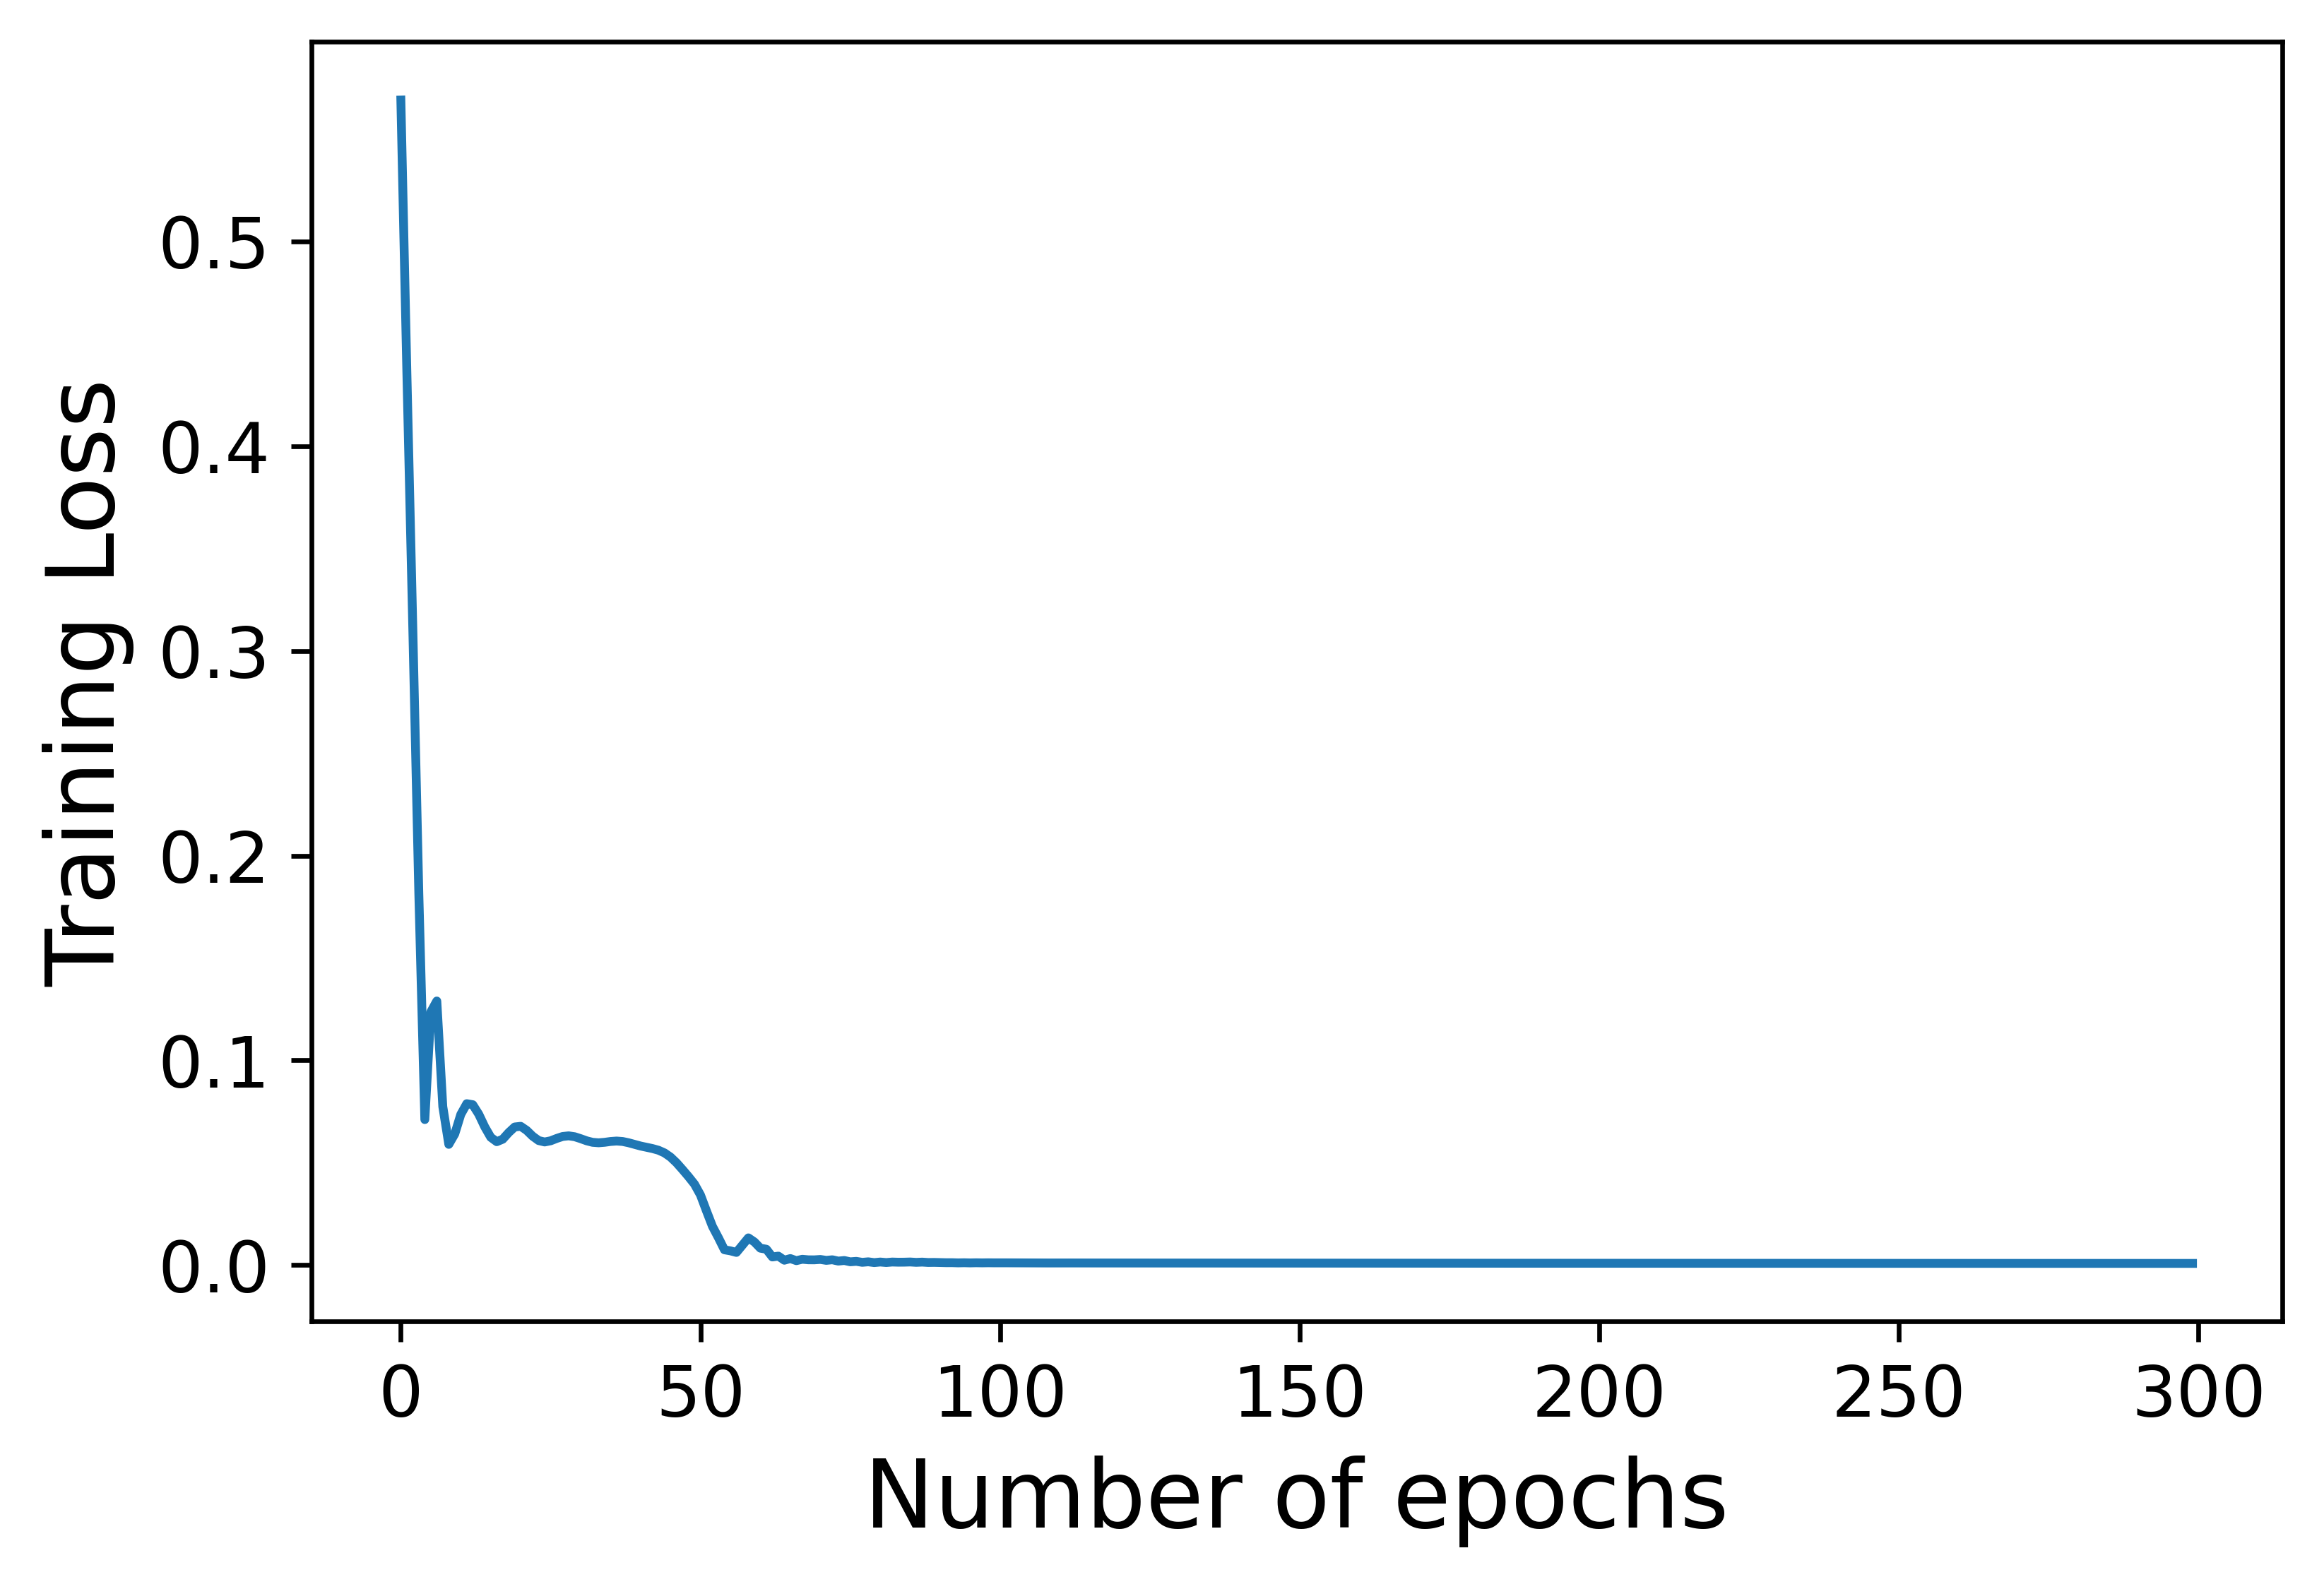

In [310]:
fig = plt.figure(figsize = [6,4], dpi = 600)
width = 2
tick_width = 1.5
ax = plt.gca()
plt.plot(training_loss)
plt.xlabel('Number of epochs',fontsize=16)
plt.ylabel('Training Loss',fontsize=16)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
# df = pd.DataFrame(training_loss)
# df.to_csv('loss_brazil.csv',index = False, header = False)

In [311]:
# predict ahead using the predicted value of the last day as input
# 8: forecast
# 18: previous
# 19: evalidate

predict = []
for predict_day in range(4):
    
    out = []
    lstm.eval()
    lstm.to(device)

    for data in forecast_loader:

        data = data.to(device)


        outputs = lstm(data)
        out.append(outputs)

    out_cat = torch.cat(out)
    out_cp = out_cat.cpu().detach().numpy()


    policy = forecasting[:, 1:-1]
    pre_X = np.concatenate((out_cp,policy), axis = 1)
    pre_X = pre_X.reshape((pre_X.shape[0], 1, pre_X.shape[1]))
    dataset_forecast = forecast(pre_X)
    forecast_loader = DataLoader(dataset_forecast,shuffle=False,batch_size=1)
    predict.append(out_cp)


In [312]:
predict

[array([[0.18906194]], dtype=float32),
 array([[0.19912821]], dtype=float32),
 array([[0.20054519]], dtype=float32),
 array([[0.20074898]], dtype=float32)]

In [313]:
outputs = []
forecast_X = forecast_X.reshape((forecast_X.shape[0], forecast_X.shape[2]))
for i in range(len(predict)):      
    inv_yhat = concatenate((predict[i], forecast_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    outputs.append(inv_yhat)


In [314]:
outputs

[array([14872.233], dtype=float32),
 array([15664.08], dtype=float32),
 array([15775.544], dtype=float32),
 array([15791.575], dtype=float32)]

In [315]:
#from pytorch_forecasting.data.examples import get_stallion_data
data = pd.read_csv("/home/mail12/Nerf-diffusion/covid_19/FINAL/TRANSFORMER/forecast_brazil.csv")
#data
data = data.drop(columns=['Unnamed: 0'])

In [316]:
cols = data.columns.tolist()
cols = cols[-1:]+cols[:-1]
cols = ['new_cases_smoothed', 'stringency_index', 'face_coverings', 'Gathering',
       'Transport', 'Stay_home']
k3 =data[cols]

In [324]:
# validate
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
#d = pd.read_csv("/home/mail12/Nerf-diffusion/covid_19/FINAL/TRANSFORMER/forecast_russia.csv")
#d_interest = d.loc[d["Country"] == "Russia"]
y = k3['new_cases_smoothed'].values[11:15]
y_pre = outputs#[1:-1]
rmse = sqrt(mean_squared_error(y, y_pre))
mae = mean_absolute_error(y,y_pre)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

Test RMSE: 6227.779
Test MAE: 6094.465


In [318]:
folder_path = '/home/mail12/Nerf-diffusion/covid_19/FINAL/LSTM/'
np.save(folder_path + 'brazil_metrics.npy', np.array([mae, rmse]))
np.save(folder_path + 'brazil_results.npy', np.array([y, y_pre]))

In [319]:
# validate
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import r2_score
# from sklearn.metrics import explained_variance_score
# d = pd.read_csv("/Users/xul2/Desktop/CMU/Research/Covid 19/7-Day Average.csv")
# d_interest = d.loc[d["Country"] == "Brazil"]
# y = d_interest["7-day-new"].values[194:211]
# y_pre = outputs[1:-1]
# rmse = sqrt(mean_squared_error(y, y_pre))
# mae = mean_absolute_error(y,y_pre)
# print('Test RMSE: %.3f' % rmse)
# print('Test MAE: %.3f' % mae)

In [320]:
# Cumulative cases calculation
# d = pd.read_csv("/Users/xul2/Desktop/CMU/Research/Covid 19/7-Day Average.csv")
# d_interest = d.loc[d["Country"] == "Russia"]
# y = d_interest["Cumulative"].values[194:212]
# # y = d_interest["Confirmed"].values[131:148]
# print(y)
# y_pre = []
# # Brazil
# b = 19151993
# # India
# b = 30946147
# # Russia
# b = 5762211
# for i in range(len(outputs)-1):
#     b = b+outputs[i+1]
#     y_pre.append(b)
# df = pd.DataFrame(y_pre)
# df.to_csv('lstm_russia_pre.csv',index = False, header = False)

In [321]:
# Compare with previous study
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import r2_score
# from sklearn.metrics import explained_variance_score
# d = pd.read_csv("/Users/xul2/Desktop/CMU/Research/Covid 19/previous.csv")
# d_interest = d.loc[d["Country"] == "France"]
# y = d_interest["Confirmed"].values[131:148]
# print(y)
# y_pre = []
# # Italy
# b = 232997
# # Spain
# b = 239479
# # # France
# b = 190975
# # # US
# #b = 1798718
# for i in range(len(outputs)-1):
#     b = b+outputs[i+1]
#     y_pre.append(b)
# rmse = sqrt(mean_squared_error(y, y_pre))
# mae = mean_absolute_error(y,y_pre)
# print('Test RMSE: %.3f' % rmse)
# print('Test MAE: %.3f' % mae)
    